# Network Analysis

Now that we have defined all of our trendy businesses in Cleveland, we must identify our 'trendy' users & their levels of influence.

Side Note: As with the other notebook, much of the cleaning & filtering of data has been left out of
of this notebook to make the logic simpler to understand. In addition, much of the code in the notebook
was created so that it could be applied to any city from the original dataset, not just Cleveland.

In [26]:
from IPython.display import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

import networkx as nx
from networkx.algorithms import bipartite

## Load in Dataframes of Pretrending Info

Load in our 'pretrending dataframes'. These dataframes contain each of our 'trendy' businesses pretrending information. This filtering was done in PostgreSQL. The DFs contain the following important info:

- Pretrending_business_info = business_ids along with the year & month a business began trending on
- Pretrending_reviews = review_ids along with all reviews that occurred before a business began trending
- Pretrending_users = user_ids along with user info for users who reviewed a business prior to it beginning to trend


### How do we define a user's 'trendiness'?

**A user's trendiness is defined by the number of businesses he or she visited prior to those businesses beginning to trend.**



In [2]:
#cleveland pretrending dataframes
pretrending_business_info = pd.read_csv("/Users/DanielCervoni/Documents/Data_Science/Yelp_Capstone_Work/yelp_dataset_challenge_round9/Yelp_Cleaned_Datasets/first_occurrence_trending_business.csv")
pretrending_reviews = pd.read_csv("/Users/DanielCervoni/Documents/Data_Science/Yelp_Capstone_Work/yelp_dataset_challenge_round9/Yelp_Cleaned_Datasets/pre_trending_reviews.csv")
pretrending_users = pd.read_csv("/Users/DanielCervoni/Documents/Data_Science/Yelp_Capstone_Work/yelp_dataset_challenge_round9/Yelp_Cleaned_Datasets/pre_trending_users.csv")

In [19]:
pretrending_business_info.head()

,business_id,name,year,month,review_count,avg_monthly_rating,city,state,categories
0,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,2011,8,15,4.00,Las Vegas,NV,"[u'Steakhouses', u'Restaurants', u'Cajun/Creole']"
1,-050d_XIor1NpCuWkbIVaQ,Matt's Big Breakfast,2009,1,11,4.55,Phoenix,AZ,"[u'Restaurants', u'Breakfast & Brunch']"
2,-0t6o9LXMVQ3aV8CHhRTnA,AZ International Marketplace,2016,4,12,2.67,Phoenix,AZ,"[u'Ethnic Grocery', u'International Grocery', ..."
3,-1UMR00eXtwaeh59pEiDjA,Matt's Big Breakfast,2016,5,10,4.20,Phoenix,AZ,"[u'Food', u'Breakfast & Brunch', u'Sandwiches'..."
4,-3oxnPPPU3YoxO9M1I2idg,Eklectic Pie,2015,12,10,4.60,Phoenix,AZ,"[u'Bars', u'Pizza', u'Nightlife', u'Salad', u'..."


In [20]:
pretrending_reviews.head()

,user_id,useful,review_type,text,stars,review_id,funny,date,cool,business_id,year,month,day,name,city,state
0,YOChRzTztTL_KooP9wEtSQ,2,review,Yummy! I didn't realize this was an Emeril (t...,5,dIcxp2EISkirAkhdNP5e1A,2,2010-03-10,2,--9e1ONYQuAa-CB_Rrw7Tw,2010,3,10,Delmonico Steakhouse,Las Vegas,NV
1,FfGSskrEu9jHlPy4sM8VBg,0,review,its about on par with craft steak...the sides ...,4,K-dD7VJ7XQ9MmGlkdsd9Dg,0,2009-08-22,0,--9e1ONYQuAa-CB_Rrw7Tw,2009,8,22,Delmonico Steakhouse,Las Vegas,NV
2,GMWHx-rH9r3FgovM9BEBhw,0,review,Good food. Great steak/beef tartare (did I sp...,3,5r4q82W5BRc7mPqfWz0hBA,0,2008-08-03,0,--9e1ONYQuAa-CB_Rrw7Tw,2008,8,3,Delmonico Steakhouse,Las Vegas,NV
3,sKTc9Sst8L0RMZNL_5JWwA,1,review,The lamb is delicious! The atmosphere is wonde...,4,gkV5kYV3jmzTYINZJzDA9A,0,2011-05-31,0,--9e1ONYQuAa-CB_Rrw7Tw,2011,5,31,Delmonico Steakhouse,Las Vegas,NV
4,oKLXD9P5JTBJ55DjsBzM0g,0,review,I've been to this restaurant 3 times in the la...,2,lHSdGdLx0mN7f5XFJ13v-g,0,2008-01-14,0,--9e1ONYQuAa-CB_Rrw7Tw,2008,1,14,Delmonico Steakhouse,Las Vegas,NV


In [21]:
pretrending_users.head()

,yelping_since,user_id,useful,type,review_count,name,funny,friends,fans,elite,...,compliment_note,compliment_more,compliment_list,compliment_hot,compliment_funny,compliment_cute,compliment_cool,average_stars,cleaned_friends,cleaned_elite_years
0,2008-01-14,O7ojHP59iSi32uhEDUR44A,9,user,689,Jasmine,9,"[u'S9chc-kdFyZXxoyhALzIpw', u'c_slXA85If5xdhop...",26,"[u'2011', u'2016', u'2012', u'2015', u'2014', ...",...,8,2,0,7,16,1,16,3.65,"[S9chc-kdFyZXxoyhALzIpw, c_slXA85If5xdhopLTDuu...","[2011, 2016, 2012, 2015, 2014, 2010, 2013]"
1,2010-09-11,qcoXFeuo8-izVUTDMiUQrg,338,user,283,Charly,80,"[u'yFu4dYTEYnvI7HwqIqAf0A', u'HdpM9p4WgWH9TNUy...",7,"[u'2017', u'2015', u'2012', u'2016', u'2013', ...",...,6,0,0,18,29,0,29,3.91,"[yFu4dYTEYnvI7HwqIqAf0A, HdpM9p4WgWH9TNUy4ee0C...","[2017, 2015, 2012, 2016, 2013, 2014]"
2,2010-08-16,nGCoZDCgM82E0mZJCQgcaw,1,user,9,Robin,1,"[u'0Ozol_VofME5C6oZg_6wNQ', u'cyOWHQtZr1vsxep7...",1,[u'None'],...,0,1,0,0,0,0,0,4.33,"[0Ozol_VofME5C6oZg_6wNQ, cyOWHQtZr1vsxep7_rdW1...",[None]
3,2009-12-25,sjZ3ScfAJ2bjDVI6MmSNGA,17,user,154,R,5,"[u'tBlvnzbaj6ZlvgzQaod7kQ', u'IzOZlhuCAaAJbxwz...",6,[u'None'],...,1,2,0,0,2,0,2,3.47,"[tBlvnzbaj6ZlvgzQaod7kQ, IzOZlhuCAaAJbxwzreGa5...",[None]
4,2010-02-25,_Q9xpq2UF4-b-WImsziwZg,25,user,26,Garrett,4,"[u'XhQyWgHLE54T0LdPWOkldw', u'cle7fLm-MBwHAR2D...",0,[u'None'],...,0,0,0,0,0,0,0,4.22,"[XhQyWgHLE54T0LdPWOkldw, cle7fLm-MBwHAR2DgP_0H...",[None]


In [15]:
pretrending_business_info.city.value_counts()

Phoenix             945
Las Vegas           765
Toronto             265
Charlotte           172
Cleveland           136
Pittsburgh          108
Madison              55
Champaign-Urbana     20
Name: city, dtype: int64

---
## Network Analysis: Businesses & 'Trendy' Reviewers

We next create a dataframe which includes the business_id & all of the reviewers for that business. This will allow us to more easily create our bipartite graph for network analysis.

In [17]:
#create dataframes of business_ids and array of reviewers
cleveland_bid_reviewers = business_reviewers_by_city('Cleveland', pretrending_business_info, pretrending_reviews)

In [18]:
cleveland_bid_reviewers.head()

,business_id,array_of_reviewers,review_count
0,0jHZk9RrKh0uRhTRW1XIqQ,"[Htx0bjQtOsoEIVBoSbjh5g, L6wUxmUErIR7FJijgr6nU...",4
1,0qsarzXaZau8REdE0rToxA,"[qbjF0SFMb7KQfJjU4MDfVQ, R1fbgO9IfwsHzPX_Mex2h...",111
2,1veVZUawy7IhIc5oDpRRQA,"[gHNpwcLKV_rlalBcZDYdmQ, VWJ8PSz6Sg5_AlBvQyGvp...",143
3,26Uk74dNTGysPq2ceaj2OA,"[9jYd1Oyet0rsbiaLynctjw, -UsqBygSimY0lDEmMvegk...",64
4,2nn6Sx5EFpzFbsy5cJYHUg,"[1C4RBKxpuIQFOaBw-3brdg, XaA9E2eXYvwZ9KH4SlpzP...",11


## Create Bipartite Graph, Calculate Degree Centrality

A **bipartite graph** makes the most sense in this case, because we have two distinct sets of nodes: businesses & reviewers.

Because we don't value one businesses connection over another, and we simply care about the total number of businesses a user visited in the pretrending period, **degree-centrality** is the most sensible measure.

In [24]:
#create the bipartite graph and the degree centrality_score
def create_bipartite_graphs_dcscore(city_df):
    #instantiate bipartite graph
    B = nx.Graph()

    #add business nodes to graph
    business_nodes = city_df.business_id.tolist()
    B.add_nodes_from(business_nodes, bipartite = 0)
    
    #add reviewer nodes to graph, set for unique values only
    reviewer_nodes = set([y for x in city_df.array_of_reviewers for y in x])
    B.add_nodes_from(reviewer_nodes, bipartite = 1)
    
    #zip ids and review arrays
    bizid_reviewer_list = zip(city_df.business_id, city_df.array_of_reviewers)

    #create unique tuples for each business_id and reviewer, these will represent edges
    bizid_reviewer_tups = []
    for bus_id, rev_id in bizid_reviewer_list:
        for reviewer in rev_id:
            bizid_reviewer_tups.append((bus_id,reviewer))
            
    #add edges to graph
    B.add_edges_from(bizid_reviewer_tups)
    
    #calculate degree centrality
    dc_score = nx.bipartite.degree_centrality(B, reviewer_nodes)
    dc_score_sorted = sorted(dc_score.items(), key=lambda x: x[1], reverse=True)
    
    #the networkx package returns a dictionary with the degree centrality for both node sets..remove business_id dc's
    dc_score_sorted = filter(lambda tup: tup[0] not in business_nodes, dc_score_sorted)
    
    
    return business_nodes, reviewer_nodes, B, dc_score_sorted

In [25]:
#create bipartite graphs for each city
clb_nodes, clr_nodes, cleveland_br_graph, cle_br_dc_sorted = create_bipartite_graphs_dcscore(cleveland_bid_reviewers)

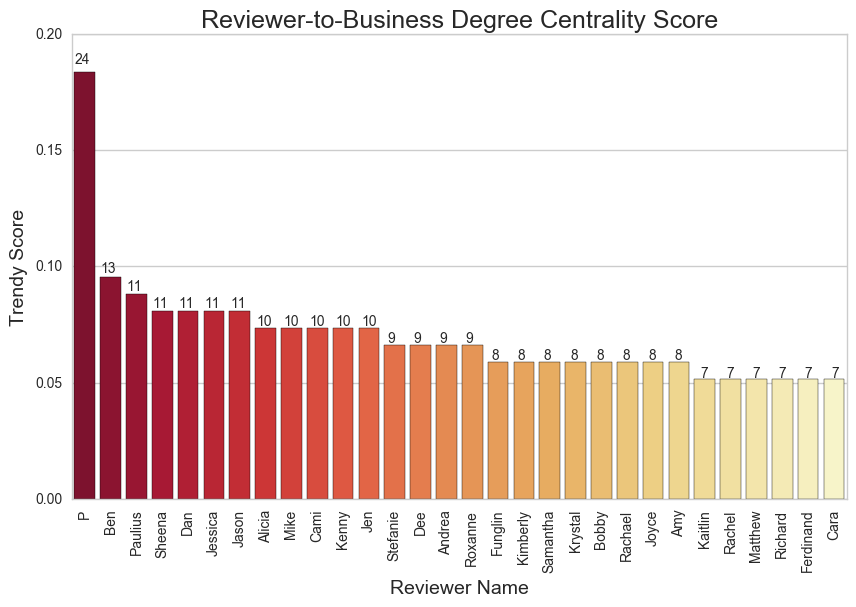

In [53]:
#dc scores
Image(filename = "/Users/DanielCervoni/Desktop/rtbdc.png")

We now have our degree centrality scores for our trendiest reviews. Above is a plot of the top 30 along with the number of trendy businesses they visited. Keep in mind rapid decrease in 'trendiness' even within the top 30 users (+40% drop from 2-30).

This tells us that a small number of individuals hold all the majority of the trending power.

## Network Analysis of Influencers

We have list of all of our trendiest users, sorted from most trendy to least. But we also want to know the level of influence they have on their social circles? Which of these users are not only trendy, but also able to influence their friends to write reviews for those same places.

---

### Defining Influence

**A user’s influence can be measured by the number of his or her friends that reviewed the same business 2 months of less after the initial ‘trendy’-user’s review.**

Because we look at all the user's friends who review a business up to 2 months after the initial user's review, we must look at all reviews that occurred up to 2 months after the business began trending, since a user could review the business the day before the trending period begins. Therefore, we need to load in new dataframes from PostgreSQL with that data.

---
### Load in Influence Dataframes

In [29]:
#first_degree_influence_cutoff_cleaned already called at beginning, call our other dataframes
reviews_prior_to_influence_threshold = pd.read_csv("/Users/DanielCervoni/Documents/Data_Science/Yelp_Capstone_Work/yelp_dataset_challenge_round9/Yelp_Cleaned_Datasets/reviews_prior_to_influence_threshold.csv")
users_prior_to_influence_threshold = pd.read_csv("/Users/DanielCervoni/Documents/Data_Science/Yelp_Capstone_Work/yelp_dataset_challenge_round9/Yelp_Cleaned_Datasets/users_prior_to_influence_threshold.csv")

In [30]:
#convert review dates to datetime format
reviews_prior_to_influence_threshold.date = pd.to_datetime(reviews_prior_to_influence_threshold.date)

In [31]:
#clean this users_df as well with the function we created earlier clean_user_friend_array
users_prior_to_influence_threshold = clean_column_array(users_prior_to_influence_threshold, 'friends', 'cleaned_friends')
users_prior_to_influence_threshold = clean_column_array(users_prior_to_influence_threshold, 'elite', 'cleaned_elite_years')

---
### Preparing the Data

We now need to get our data into a list of tuples, where each tuple includes a business_id, reviewer_id, and a friend of the reviewer that he or she influenced to make a review on that same business. This will get our data into the right for to pass into NetworkX & create our directed graph.

We have a dictionary called "cleveland_first_degree_info", where each key is a tuple of (business, initial_reviewer) & each value is a list of all the initial-reviewer's friends that visited that same business (regardless of when they visited it).

cleveland_first_degree_info =

{(business_id1, user_id1): [friend1, friend2, friend3, ...],
(business_id1, user_id2): [friend1, friend2, friend3, ...],
...}


We pass that dictionary into a function to filter out the friends who did NOT review the business within 2 months of the initial-reviewer's review (i.e. they were not influenced by the initial reviewer).

In [38]:
#for each id in our pretrending_unique_ids dataframe, we need to compare their review date for each
#business they reviewed with that of their friends
def filter_out_friends_influenced(df):

    #to append tuples
    business_reviewer_and_influenced_reviewers = []

    #loop through each user and create a single row df based on a match from the reviews df and our tuple values
    for key, value in df.items():
        user_review_date = pretrending_reviews.loc[(pretrending_reviews.business_id == key[0]) & 
                                                                    (pretrending_reviews.user_id == key[1]), 'date']     

        user_review_date = user_review_date.values

        #loop through list each friend of the reviewer that also reviewed the business in tup[2]
        for friend in value:
            friend_review_date = reviews_prior_to_influence_threshold.loc[(reviews_prior_to_influence_threshold.business_id == key[0]) & 
                                                                          (reviews_prior_to_influence_threshold.user_id == friend), 'date']

            friend_review_date = friend_review_date.values
            diff = pd.to_timedelta(friend_review_date - user_review_date).days

            #append business_id, reviewer, and influenced_reviewer as a tuple to a list
            if (diff > 0) and (diff <= 62):
                business_reviewer_and_influenced_reviewers.append((key[0], key[1], friend))
    
    return business_reviewer_and_influenced_reviewers


In [39]:
cleveland_tuples_influenced_friends = filter_out_friends_influenced(cleveland_first_degree_info)

**Our output is a list of tuples, where each tuple is a (business, user, friend). This tuple represents our list of all the instances of influence that occurred in this network for our 'trendy' reviewers.** We now have our data in the correct form to pass into NetworkX.

---
### Create Influencer Network Graphs

Because **influence only works in one direction**, and we have nodes that were both influencers & influenced, we create a **directed graph** between our reviewers & their friends they influenced. Each instance of influence is an edge in this graph.

In [46]:
#create edges from trendsetting reviewers to their first degree connections they 'influenced'
reviewers_and_1stdeg_connects = [(tup[1], tup[2]) for tup in cleveland_tuples_influenced_friends]

In [47]:
#directed graph of reviewers to influenced reviewers function
def create_directed_graph(city_df, lst_of_tuples):
    '''Create directed graph for reviewers_to_influenced_reviewers'''
    
    #instantiate directed graph
    G = nx.DiGraph()
    
    #create unique sets of user_nodes
    reviewer_nodes = list((set([y for x in cleveland_bid_reviewers.array_of_reviewers for y in x])))
    first_degree_connect_nodes = list((set([tup[1] for tup in lst_of_tuples])))

    #append nodes from first_degree_connect that aren't in reviewer_nodes so we can have a full list of our nodes
    user_node_list = reviewer_nodes + list(set(first_degree_connect_nodes) - set(reviewer_nodes))

    #add reviewer nodes to graph, set for unique values only
    G.add_nodes_from(user_node_list)
            
    #add edges to graph
    G.add_edges_from(lst_of_tuples)
    
    return reviewer_nodes, first_degree_connect_nodes, G

In [48]:
#let's create the directed graph connecting reviewers to influenced revieweres
clr_nodes, clr_fdc_nodes, cleveland_r_to_ir_graph = create_directed_graph(cleveland_bid_reviewers, reviewers_and_1stdeg_connects)

---
### Plotting & Analyzing the Network

We have our graphs and can now begin to analyze them. After plotting multiple different subsections of our graph, one thing I came to realize was the power distribution that was occuring within our graph. 

Below are 2 networks, one with our top 20 influencers, and the other with our top 21-100 influencers. Both have 75 instances of influence within their networks, yet one network reaches this milestone with 60 less individuals. **This proves that much of the influential power is held in the hands of the few, and that many of the most influential people are very likely to influence each other.** 

0.194736842105


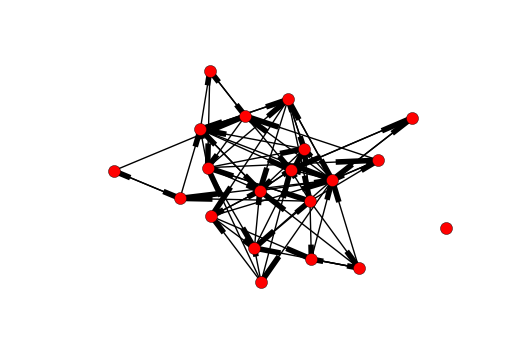

In [92]:
#top 20 influencers' network plotted
k = cleveland_r_to_ir_graph.subgraph([tup[0] for tup in cle_r_to_ir_dc_sorted[0:20]])  
spring_pos = nx.spring_layout(k)
plt.axis("off")
nx.draw_networkx(k, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = 'r', node_size = 75, with_labels = False)
print nx.density(k)

0.0123336579033


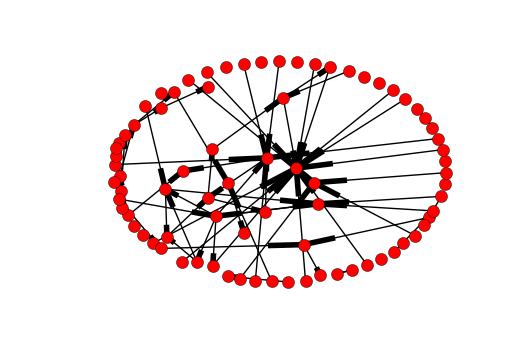

In [91]:
#top 21-100 influencers' network plotted
k = cleveland_r_to_ir_graph.subgraph([tup[0] for tup in cle_r_to_ir_dc_sorted[21:100]])  
spring_pos = nx.spring_layout(k)
plt.axis("off")
nx.draw_networkx(k, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = 'r', node_size = 75, with_labels = False)
print nx.density(k)

---
### Centrality Measures: Degree & Eigenvector

Because of this, calculating our eigenvector centrality, along with our degree centrality, is important. Eigenvector centrality places a premium score on those users who influence other highly influential users. It represents the **2nd-degree level of influence of our users**. While this is not the focus of my foundational analysis, it will be a critical component to build future analysis on and to better understand how influence is transferred from one person to another over time.

In [49]:
#cleveland reviewers to influenced_reviewers out_degree_centrality, #1840 possible users to influence
cle_r_to_ir_dc = nx.out_degree_centrality(cleveland_r_to_ir_graph)
cle_r_to_ir_dc_sorted = sorted(cle_r_to_ir_dc.items(), key=lambda x: x[1], reverse=True)

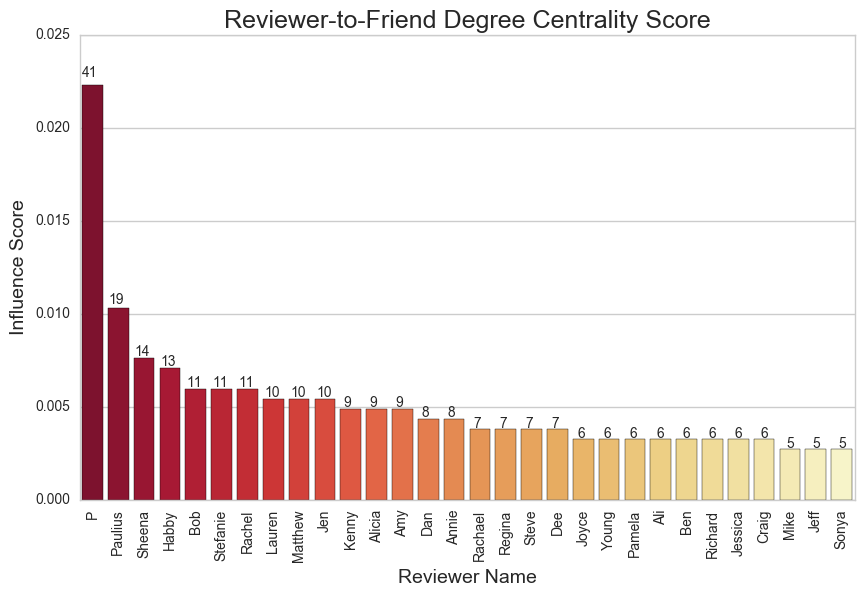

In [52]:
Image(filename = "/Users/DanielCervoni/Desktop/rtidc.png")

### Eigenvector Centrality 

In [54]:
ec = nx.eigenvector_centrality(cleveland_r_to_ir_graph.reverse())
ec_sorted = sorted(ec.items(), key=lambda x: x[1], reverse=True)

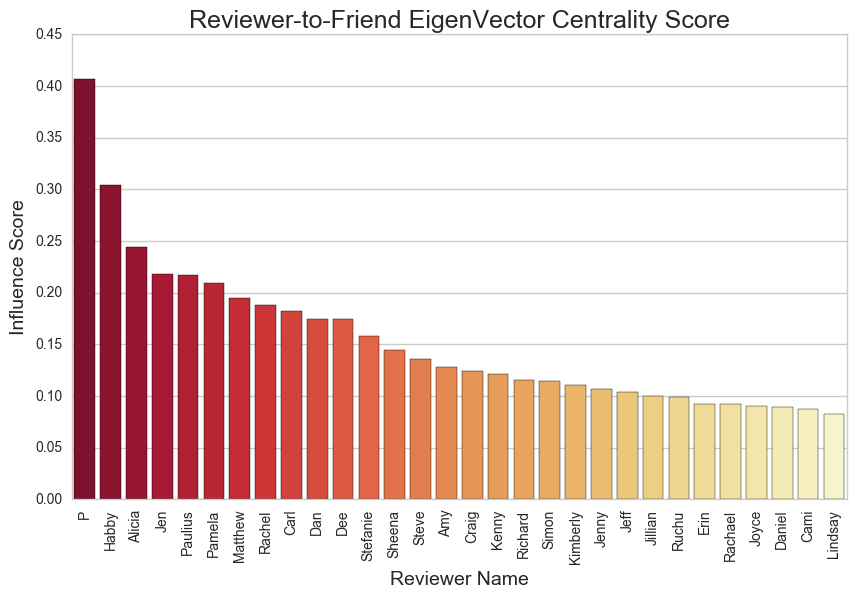

In [55]:
Image(filename = '/Users/DanielCervoni/Desktop/eigenc.png')

### Normalized Trendy_Influence_Scores Per User - Top 10

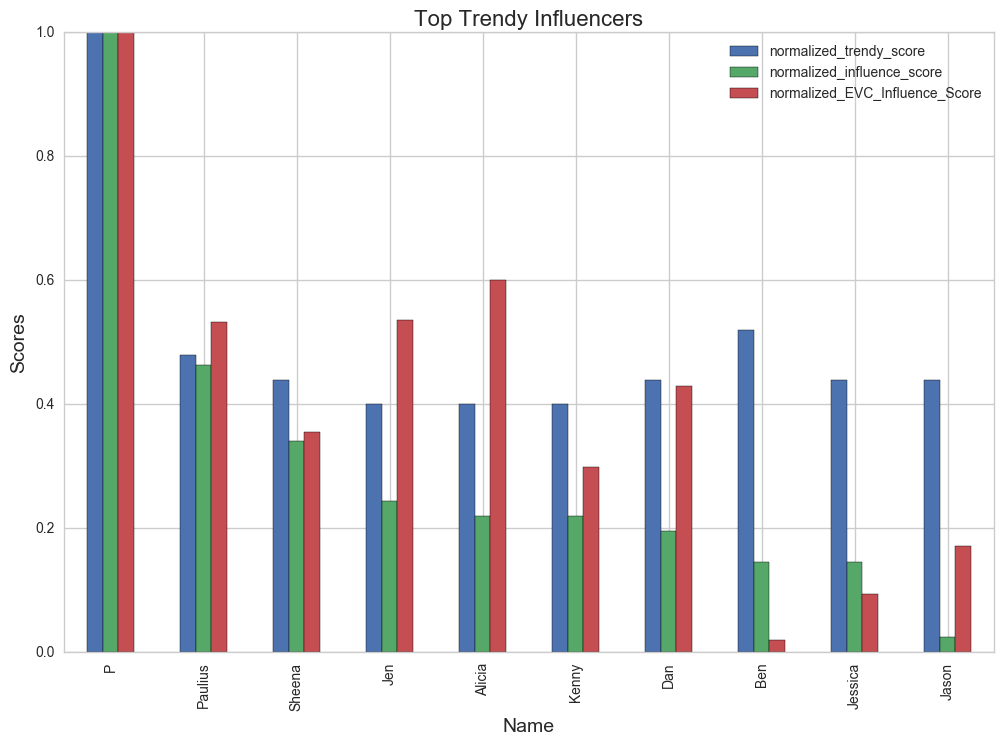

In [93]:
sns.set_style("whitegrid")
trend_setting_influence_scores_df.head(10).groupby(['name'])['normalized_trendy_score', 'normalized_influence_score', \
                                                        'normalized_EVC_Influence_Score'].sum().sort_values(by = 'normalized_influence_score', ascending = False).plot(kind = 'bar', figsize = (12, 8))
plt.title("Top Trendy Influencers", fontdict = {"fontsize": 16})
plt.xlabel("Name", fontdict = {"fontsize": 14})
plt.ylabel("Scores", fontdict = {"fontsize": 14})